# Example: Function Fitting

This example involves basic plotting with Matplotlib and function fitting with Scipy.Optimize.

(see: http://matplotlib.org/ and https://docs.scipy.org/doc/scipy/reference/optimize.html)


## Motivation

Imagine the following situation: you are handed some data (https://raw.githubusercontent.com/mommermi/Introduction-to-Python-for-Scientists/master/notebooks/signal.csv) - some signal $y$ with corresponding uncertainties $\sigma_y$ as a function of $x$ - and you have to find a function that describes the data. What to do?

Of course, let's have a look at the data first and plot them.


## Basic Plotting with Matplotlib

In [1]:
# matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# read in signal.csv
data = np.genfromtxt('signal.csv', delimiter=',', 
                     dtype=[('x', float), ('y', float), ('yerr', float)])

Let's plot the data in a very simple scatter plot:

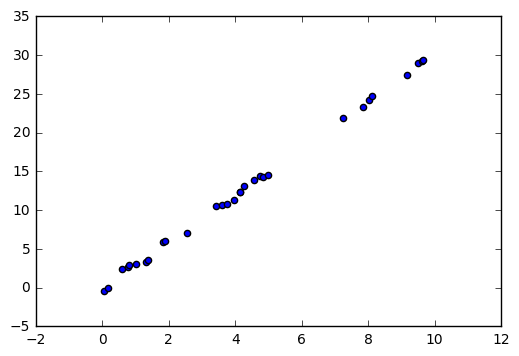

In [2]:
f, ax = plt.subplots()
ax.scatter(data['x'], data['y'])
plt.show()

The first line creates two things: a figure (`f`) and a subplot (`ax`), which is referred to as an **axis** (see http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.subplots). You can create a panel with multiple subplots (see below). The second line uses the subplot `ax` and creates a scatter plot with the provided $x$ and $y$ data. The `scatter` function can use different symbols and colors (see http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter). 

Let's add some axis labels and a legend, use errorbars and change the symbol color: 

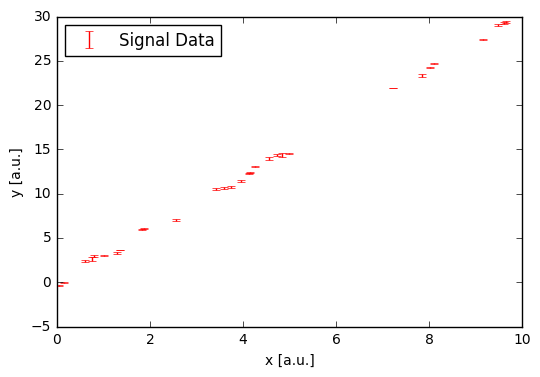

In [3]:
f, ax = plt.subplots()
ax.errorbar(data['x'], data['y'], yerr=data['yerr'], linestyle='', color='red', label='Signal Data')
ax.set_xlabel('x [a.u.]')
ax.set_ylabel('y [a.u.]')
ax.legend(numpoints=1, loc=2)
plt.show()

The function `errorbar` plots lines with vertical errorbars; more options are available (see http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.errorbar). Calling the `legend` function adds a legend; in this case, it shows the symbol only once and appears in the top left corner (see http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.legend).

## Function Fitting

A very flexible routine that fits any kind of n-dimensional function to data is `curve_fit` in the `scipy.optimize` module (see https://docs.scipy.org/doc/scipy/reference/optimize.html). `curve_fit` uses a non-linear least-squares method (by default a Levenberg-Marquardt algorithm) to find the best-fit parameters to fit the data.

Let's start with a simple example and fit a line, $f(x) = ax + b$, to the data. As part of the fitting, those parameters $a$ and $b$ are found such that the curve $f(x)$ matches the datapoints best:

In [4]:
from scipy.optimize import curve_fit

# define the line function
def model(x, a, b): # first argument is always x, rest are parameters
    return a*x+b

# fit the use least-squares-fitting
bestfit, cov = curve_fit(model, data['x'], data['y'], sigma=data['yerr'])
print 'best fit parameters', bestfit
print 'covariance matrix', cov

best fit parameters [ 3.09724697 -0.49050537]
covariance matrix [[  4.63915412e-05  -4.12147765e-06]
 [ -4.12147765e-06   1.56418524e-05]]


`curve_fit` requires a function (in this case `model`), the first argument of which is the variable (or set of variables) over which the function is defined (`data['x']`). All the remaining arguments of the function are treated as parameters that are varied in order to find the best fit of the data against `data['y']`. The optional argument `sigma` allows for passing a list of uncertainties that serve as weights in the fitting process. Note that `len(data['x'])==len(data['y'])==len(data['yerr'])`.

The function produces two objects as output:
* the first object is a list of the best fit parameters
* the second object is a covariance matrix that allows for calculating the fit uncertainties.

Let's plot the best-fit function over the data points:

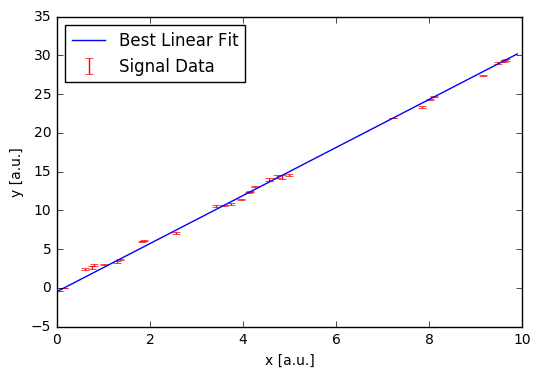

In [5]:
f, ax = plt.subplots()
ax.errorbar(data['x'], data['y'], yerr=data['yerr'], linestyle='', color='red', label='Signal Data')
ax.plot(np.arange(0, 10, 0.1), model(np.arange(0, 10, 0.1), *bestfit), label='Best Linear Fit', color='blue')
ax.set_xlabel('x [a.u.]')
ax.set_ylabel('y [a.u.]')
ax.legend(numpoints=1, loc=2)
plt.show()
# plt.savefig('filename.pdf')   # use this line to save the plot as a pdf file

The `plot` function can be used to draw a continuous line (see http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.plot). Note that the a line can simply be plotted over the scatter points.

Although the overall quality of fit is ok, most datapoints do no fall on the line. Let's calculate the *goodness of fit* parameter, the reduced $\chi^2$ (https://en.wikipedia.org/wiki/Goodness_of_fit):

In [6]:
import scipy.stats as stat
print 'chi2:', stat.chisquare(data['y'], model(data['x'], *bestfit), ddof=2)

chi2: Power_divergenceResult(statistic=2.0372644998945897, pvalue=0.99999999997842959)


Let's try to improve our model by having a look at the residuals (the difference between the $y$ datapoints and the prediction through our best-fit function `model`):

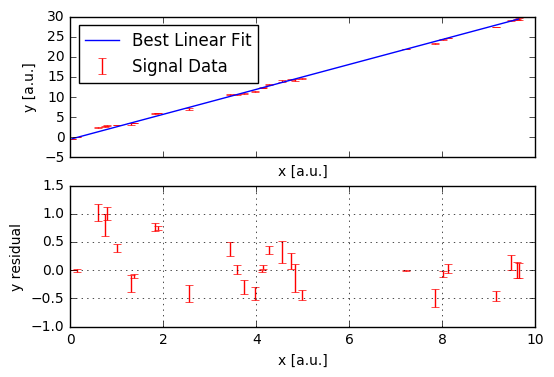

In [7]:
f, (ax1, ax2) = plt.subplots(2, sharex=True)

# top panel
ax1.errorbar(data['x'], data['y'], yerr=data['yerr'], linestyle='', color='red', label='Signal Data')
x_space = np.arange(min(data['x']), max(data['x']), 0.1)
ax1.plot(x_space, model(x_space, bestfit[0], bestfit[1]), color='blue', label='Best Linear Fit')
ax1.set_xlabel('x [a.u.]')
ax1.set_ylabel('y [a.u.]')
ax1.legend(numpoints=1, loc=2)

# bottom panel
ax2.errorbar(data['x'], data['y']-model(data['x'], bestfit[0], bestfit[1]), 
             yerr=data['yerr'], 
             linestyle='', color='red')
ax2.grid()
ax2.set_xlabel('x [a.u.]')
ax2.set_ylabel('y residual')
plt.show()


Here, we made use of two subplots that are arranged vertically and share a common x range (`plt.subplots(2, sharex=True)`). The variable `x_space` simply generates evenly spaced x values over the full range of `data['x']`. In the bottom plot, we also put a grid to make it easier to estimate how large those residuals are.

There seems to be wave pattern in the residuals. We improve our model function by adding a sine term to it: $f(x) = ax + b + \sin \left( x/d - e \right)$

In [8]:
def model(x, a, b, c, d, e): # first argument is always x, rest are parameters
    return a*x+b+c*np.sin(x/d-e)

We fit this function to the data one more time. Using `curve_fit`'s `p0` option, we provide a first guess for the fitting parameters:

In [9]:
# use least-squares-fitting
bestfit, cov = curve_fit(model, data['x'], data['y'], sigma=data['yerr'],
                         p0=[bestfit[0], bestfit[1], 0.4, 0.2, 1])

# first guess parameters p0 through manual tweaking
print 'best fit paramters', bestfit
print 'covariance matrix', cov

# determine goodness of fit
print 'chi2:', stat.chisquare(data['y'], model(data['x'], *bestfit), ddof=5)

best fit paramters [ 2.99940486  0.00471663  0.50558814  0.19998846  1.99739295]
covariance matrix [[  7.37937541e-06  -2.90025861e-05  -2.66676166e-05  -2.55117814e-07
    2.37839045e-05]
 [ -2.90025861e-05   1.43922586e-04   1.44178944e-04   1.90366471e-07
   -2.07463149e-05]
 [ -2.66676166e-05   1.44178944e-04   1.71578235e-04  -1.39921517e-06
    2.03419154e-04]
 [ -2.55117814e-07   1.90366471e-07  -1.39921517e-06   1.04159942e-07
   -1.32678307e-05]
 [  2.37839045e-05  -2.07463149e-05   2.03419154e-04  -1.32678307e-05
    1.87306837e-03]]
chi2: Power_divergenceResult(statistic=0.028326508107136637, pvalue=1.0)


The goodness of fit is now very good (actually too good...) and the covariance matrix has more elements, since there are more fit parameters. Let's have a look at the fit and the residuals using the same code as above:

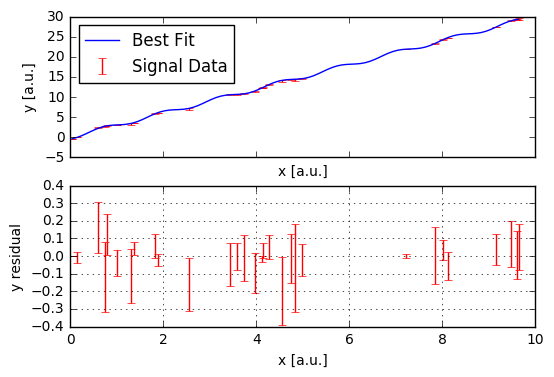

In [10]:
f, (ax1, ax2) = plt.subplots(2, sharex=True)

# top panel
ax1.errorbar(data['x'], data['y'], yerr=data['yerr'], linestyle='', color='red', label='Signal Data')
x_space = np.arange(min(data['x']), max(data['x']), 0.1)
ax1.plot(x_space, model(x_space, *bestfit), color='blue', label='Best Fit')
ax1.set_xlabel('x [a.u.]')
ax1.set_ylabel('y [a.u.]')
ax1.legend(numpoints=1, loc=2)

# bottom panel
ax2.errorbar(data['x'], data['y']-model(data['x'], *bestfit), yerr=data['yerr'], 
             linestyle='', color='red')
ax2.grid()
ax2.set_xlabel('x [a.u.]')
ax2.set_ylabel('y residual')
plt.show()

Our model now fits the datapoints nicely - actually, most residuals are smaller than the $1\sigma$ uncertainties, explaining the small value of the reduced $\chi^2$. 

An important role in the successful fit is the fact that we provided a reasonable intial guess (optional argument `p0` in `curve_fit`). Without this guess, the fit might have gotten worse. Never trust a computer blindly when fitting data! The algorithm might get stuck in a local minimum, utterly ignoring the global minimum. Always check the quality of the fit with a plot and refine the initial guess parameters, if necessary.